In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
from collections import Counter, defaultdict
from contextlib import closing, contextmanager
from dataclasses import dataclass
from functools import cached_property
from itertools import combinations, groupby, repeat
from operator import mul
from typing import Tuple

import glasbey
import pandas as pd
import pypdfium2 as pdfium
from IPython.display import SVG, display
from PIL import Image, ImageDraw, ImageFont
from rich import print
from scipy.spatial import KDTree

from box import Box
from render import render_boxes_as_image, render_boxes_as_svg

In [3]:
PMC_ARTICLE_ID = "PMC2911601"

pdf = pdfium.PdfDocument(f"data/selected/{PMC_ARTICLE_ID}.pdf")


In [4]:
@contextmanager
def page_textpage(pdf: pdfium.PdfDocument, index: int):
    """This gets the `PdfPage` and `PdfTextPage` objects in a
    context manager and closes them when finished.

    Objects can be manually closed with pypdfium,
    however they have to be closed in the right order -
    i.e. smallest to largest scope (search, textpage, page, pdf)
    """

    page = pdf.get_page(index)
    textpage = page.get_textpage()
    try:
        yield (page, textpage)
    finally:
        textpage.close()
        page.close()

In [5]:
def hex_to_rgba(hexcode: str, alpha: int):
    """Convert a Hex code (without a '#') to an RGBA (r, g, b, a) value."""
    return tuple(int(hexcode[i : i + 2], 16) for i in (0, 2, 4)) + (alpha,)


## "Non-Parametric" Page Segmentation
We're going to implement an algorithm to segment the pages into blocks based off of the `boxes` that `pypdfium` gives us. A box from `pypdfium` is a sequence of characters, of the same font style, in a row that are vertically aligned. This is sometimes referred to as a `TextRun` (e.g. in Word or Google Docs).

We're going to use concepts from two different algorithms. The first one is RLSO, and it's described in [this paper](https://dl.acm.org/doi/10.1145/1815330.1815375). A short visual description of it from a presentation is below:

<img src="https://i.postimg.cc/6Qb9NRTX/Pasted-image-20221228093221.png" width="300">

One issue with this algorithm is that it depends on a-priori defining horizontal and vertical distance. In order to do that, we're going to borrow concepts from [this paper](https://staff.fnwi.uva.nl/c.monz/html/publications/ijdar.pdf), specifically the concept of _Thick Boundary Rectangle Relations (TBRR)_, which are an adaptation of [Allen's interval algebra](https://en.wikipedia.org/wiki/Allen%27s_interval_algebra) with tolerances for the imprecision of box locations.

<img src="https://i.postimg.cc/c4Wvspd4/image.png" width="300">

We'll combine these two algorithms with some known information as follows.

First, we'll have a dynamic **horizontal distance**  $d_h$ given two boxes $a$ and $b$, which is defined as the $max(mean(character width_a) \times 2, TBD Fudge Factor)$. This is based off of the observation that two boxes should be horizontally merged if there's less than two character widths distance apart. Often boxes that are horizontally adjacent imply that box $b$ is simply using a different font than $a$ (like a symbol font for something like `<` or `[`), and thus has been split into a separate text run. The `TBD Fudge Factor` accounts for odd cases where $a$ consists of thin characters (e.g. `I`) or some other thing. **📈 This can definitely be improved and should probably just be the character width of a space (` `) within that font, if that can be identified.** If the horizontal distance between two boxes is less than this threshold, and the two boxes share some space in the y-dimension--indicating they are on the same line--then they are merged.

Second, we will have a dynamic **vertical distance** $d_v$ given two boxes $a$ and $b$, which is defined as the $height_{a} \times 1.15$. This is based off of two similar observations: _the default line spacing in Microsoft Word is 1.15_ and _the default line-height is about 110% to 120% for the majority of web browsers._ If the vertical distance between two boxes is less than this threshold, and the two boxes share some space in the x-dimension--indicating they are in the same column--then they are merged.

Some notes on this **vertical distance** choice:
- There is some margin for error here, as lines can contain no ascenders or descenders, so the height of any given box of text might be _less than_ the actual line height specified for the text. 
  - **📈 One adaptation here might be to find the $max(height)$ per font and use that instead.**
- An implication of this measure is that if vertical distance between two vertical blocks is more than the line height, it means that there is at least one blank line separating them. 
- This can have unintended consequences when $a$ has a much larger height than $b$, for example when $a$ is a heading and $b$ is the first line of a paragraph. Often times there may be less than a full line-height of $a$ separating them, and they may be merged.
  - I believe we can account for this by using style information and adapting the dynamic height here when we detect this bounding box contains a font we think is a header/title.

With that, we can apply the dynamic RLSO algorithm. A final modification we make is that we store the box centers in a KDTree, so that we don't have to investigate every pair of boxes. In this case, we use `k = n_boxes / 2` nearest neighbors for each point.

In the RLSO algorithm they call a `block` (typical name for a grouping of elements) a `frame`. Every `box` starts in it's own `frame`, then if two boxes meet either the criteria (they're adjacent and their distance is under the threshold), they are merged into the same block. We track these merges in a dictionary where the `box` is the key and the `frame` is the value, then if two boxes should be merged, it reassigns the `frame` of `box[b]` to `box[a]`. The resulting dictionary is a mapping of `box:frame`, where `frame` is the first `box` id that was merged in sequence. We merge following the rules outlined above, plus adding the constraint from TBRR that the two boxes must overlap in the dimension they're being analyzed in -- that is, they both don't `preceed` each other.

_Hopefully now it's clear why "non-parametric" is in quotes in the title. I think we have pretty good ways of defining the parameters we need (line-height threshold and character width), but it'll be a little more work to make this truly non-parametric_

In [6]:
from box import Box

In [7]:
pnumber = 0
fudge_factor = 8
line_height_mul = 1.15

with page_textpage(pdf, pnumber) as (page, textpage):
    boxes = [Box(*b) for b in textpage.get_rectboxes()]
    centers = [b.center for b in boxes]
    charwidths = [
        len(textpage.get_text_bounded(*b.as_tuple())) / b.width for b in boxes
    ]

tree = KDTree(centers)

frames = dict(((i, i) for i in range(len(boxes))))

for box_id, box in enumerate(boxes):
    lh_tolerance = box.height * line_height_mul
    charwidth = max(charwidths[box_id] * 2, fudge_factor)
    # k = n_boxes / 2
    _, neighbors = tree.query(box.center, len(boxes) // 2)
    for neighbor in neighbors[1:]:
        neighbor_box = boxes[neighbor]
        hdist = box.hdist(neighbor_box) 
        y_tol = (line_height_mul - 1) * box.height
        # hdist must be positive, otherwise we will merge right-to-left
        horizontally_adjacent = 0 < hdist < charwidth and not (
            box.precedes_y(neighbor_box, y_tol)
            or neighbor_box.precedes_y(box, y_tol)
        )
        if horizontally_adjacent:
            frame = frames[box_id]
            frames[neighbor] = frame
            # print(f"{box_id}:{neighbor} Merged Horizontally")
            continue

        vdist = box.vdist(neighbor_box)
        vertically_adjacent = 0 < vdist < lh_tolerance and not (
            box.precedes_x(neighbor_box, charwidth)
            or neighbor_box.precedes_x(box, charwidth)
        )

        if vertically_adjacent:
            frame = frames[box_id]
            frames[neighbor] = frame
            # print(f"{box_id}:{neighbor} Merged Vertically")


In [8]:
sorted_frames = list(sorted(frames.items(), key=lambda x: x[1]))
frame_groups = [
    (frame, list(i[0] for i in bboxes))
    for frame, bboxes in groupby(sorted_frames, key=lambda x: x[1])
]
merged_boxes = {}
for frame, bboxes in groupby(sorted_frames, key=lambda x: x[1]):
    bboxes = list(bboxes)
    x1 = min(boxes[i[0]].x1 for i in bboxes)
    y1 = min(boxes[i[0]].y1 for i in bboxes)
    x2 = max(boxes[i[0]].x2 for i in bboxes)
    y2 = max(boxes[i[0]].y2 for i in bboxes)
    merged_boxes[frame] = Box(x1, y1, x2, y2)


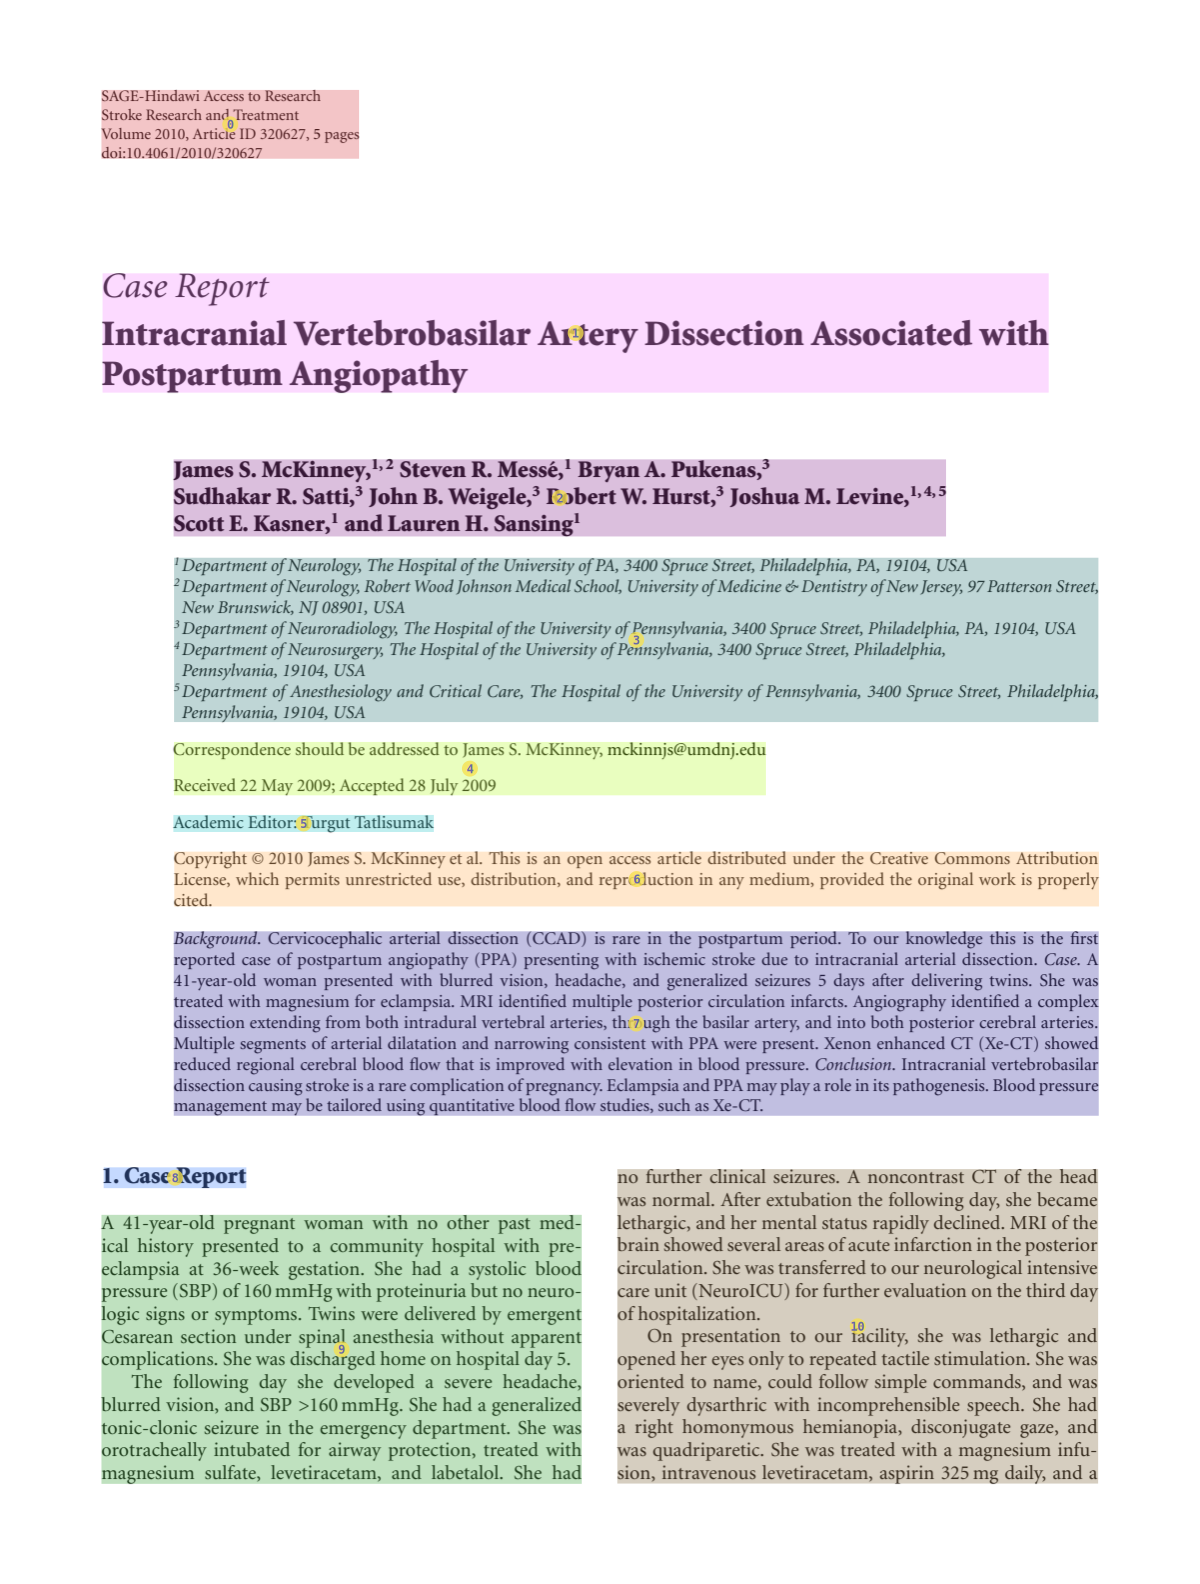

In [9]:
frame_ids = set(frames.values())
colors = glasbey.create_palette(len(frame_ids))
colors_map = {f: hex_to_rgba(c.lstrip("#"), 64) for f, c in zip(frame_ids, colors)}
colormap = {b: colors_map[f] for b, f in frames.items()}

merged_boxes_l = list(merged_boxes.values())
box_colors = [colors_map[f] for f in merged_boxes.keys()]
img_mgd = render_boxes_as_svg(
    pdf.get_page(pnumber),
    merged_boxes_l,
    box_colors=box_colors,
    scale=1,
)
display(SVG(img_mgd))